# # Ethiopian Bank Reviews - Task 1: Data Collection
# 
# **Objective**: Scrape and preprocess Google Play Store reviews for 3 Ethiopian banks
# 
# Banks:
# - Commercial Bank of Ethiopia (CBE)
# - Bank of Abyssinia (BOA)
# - Dashen Bank

In [49]:
# Import required modules
import sys
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import logging  # Ensure this import is present

# Ensure the parent directory of 'src' is in the Python path
sys.path.append(os.path.abspath('../'))

# Import from your modules
from src.data_collection.scraper import BankReviewScraper
from src.data_collection.preprocessor import ReviewPreprocessor
from config.settings import BANKS

In [50]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [51]:
# Initialize components
scraper = BankReviewScraper()
preprocessor = ReviewPreprocessor()

### 1. Scrape Raw Reviews

In [52]:
# Scrape each bank's reviews
raw_reviews = {}
for bank_name, app_id in BANKS.items():
    logger.info(f"Scraping {bank_name}...")
    try:
        reviews = scraper.scrape_bank(app_id, bank_name)
        raw_reviews[bank_name] = reviews
        logger.info(f"✅ Successfully scraped {len(reviews)} reviews")
    except Exception as e:
        logger.error(f"❌ Failed to scrape {bank_name}: {str(e)}")
        continue

INFO:__main__:Scraping Commercial Bank of Ethiopia...
Scraping Commercial Bank of Ethiopia: 100%|██████████| 400/400 [00:07<00:00, 56.10it/s]
INFO:__main__:✅ Successfully scraped 400 reviews
INFO:__main__:Scraping Bank of Abyssinia...
Scraping Bank of Abyssinia: 100%|██████████| 400/400 [00:07<00:00, 50.62it/s]
INFO:__main__:✅ Successfully scraped 400 reviews
INFO:__main__:Scraping Dashen Bank...
Scraping Dashen Bank: 100%|██████████| 400/400 [00:07<00:00, 51.83it/s]
INFO:__main__:✅ Successfully scraped 400 reviews


In [53]:
# Preview raw data structure
if raw_reviews:
    sample_bank = list(raw_reviews.keys())[0]
    print(f"\nSample review structure from {sample_bank}:")
    print(raw_reviews[sample_bank][0])


Sample review structure from Commercial Bank of Ethiopia:
{'reviewId': 'be2cb2ac-bbe0-4175-81c4-9f6c86afdaaa', 'userName': 'Aim4 Beyond', 'userImage': 'https://play-lh.googleusercontent.com/a/ACg8ocJ8haRPi_VW5lsN16hQDpUE8f3f24u6P2mvRwSw8wBpampb4g=mo', 'content': '"Why don’t your ATMs support account-to-account transfers like other countries( Kenya, Nigeria , South africa)"', 'score': 4, 'thumbsUpCount': 0, 'reviewCreatedVersion': None, 'at': datetime.datetime(2025, 6, 6, 9, 54, 11), 'replyContent': None, 'repliedAt': None}


In [58]:
output_dir = Path("data/raw")
output_dir.mkdir(parents=True, exist_ok=True)

if raw_reviews and isinstance(raw_reviews, dict):
    # Save individual bank files
    for bank_name, reviews in raw_reviews.items():
        if reviews:  # Check if the list of reviews is not empty
            df = pd.DataFrame(reviews)  # Convert list of dicts to DataFrame
            filename = output_dir / f"{bank_name.lower().replace(' ', '_')}_raw.csv"
            df.to_csv(filename, index=False)
            print(f"Saved {len(df)} reviews to {filename}")
        else:
            print(f"Warning: No reviews found for {bank_name}.")

    # Save combined file if combined_df is defined
    if 'raw_combined_df' in locals():
        raw_combined_path = output_dir / "raw_all_banks_combined.csv"
        raw_combined_df.to_csv(raw_combined_path, index=False)
        print(f"\nSaved combined data to {raw_combined_path}")
    else:
        print("Warning: combined_df is not defined.")
else:
    print("No raw reviews to save or the structure is incorrect.")

Saved 400 reviews to data\raw\commercial_bank_of_ethiopia_raw.csv
Saved 400 reviews to data\raw\bank_of_abyssinia_raw.csv
Saved 400 reviews to data\raw\dashen_bank_raw.csv

Saved combined data to data\raw\raw_all_banks_combined.csv


In [61]:
# Combine all bank data before preprocess
if raw_reviews:
    raw_combined_df = pd.concat(clean_dfs, ignore_index=True)
    print("\nCombined dataset preview:")
    display(combined_df.head(3))
    
    # Basic stats
    print("\n📊 Data Summary:")
    print(f"Total reviews: {len(combined_df)}")
    print("\nReviews per bank:")
    print(raw_combined_df['bank'].value_counts())


Combined dataset preview:


,review_id,review,rating,date,bank,source
0,c1698da217f8f1f69ec3f269f2adaed3,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play
1,07bec0f87319f8e9e6541da2883b2916,what is this app problem???,1,2025-06-05,Commercial Bank of Ethiopia,Google Play
2,77db45e9bb9e610a42cd16c8560ce6fd,the app is proactive and a good connections.,5,2025-06-05,Commercial Bank of Ethiopia,Google Play



📊 Data Summary:
Total reviews: 815

Reviews per bank:
bank
Dashen Bank                    310
Bank of Abyssinia              259
Commercial Bank of Ethiopia    246
Name: count, dtype: int64


### 2. Clean and Preprocess Data

In [56]:
# Process each bank's data
clean_dfs = []
for bank_name, reviews in raw_reviews.items():
    try:
        clean_df = preprocessor.clean_data(reviews, bank_name)
        clean_dfs.append(clean_df)
        logger.info(f"✅ Processed {len(clean_df)} {bank_name} reviews")
    except Exception as e:
        logger.error(f"❌ Failed to process {bank_name}: {str(e)}")
        continue


INFO:__main__:✅ Processed 246 Commercial Bank of Ethiopia reviews
INFO:__main__:✅ Processed 259 Bank of Abyssinia reviews
INFO:__main__:✅ Processed 310 Dashen Bank reviews


In [62]:
# Combine all bank data from raw reviews
if raw_reviews and isinstance(raw_reviews, dict):
    combined_raw_reviews = []

    for bank_name, reviews in raw_reviews.items():
        if reviews:  # Ensure there are reviews for the bank
            df = pd.DataFrame(reviews)
            df['bank'] = bank_name  # Add a column for the bank name
            combined_raw_reviews.append(df)
    
    if combined_raw_reviews:
        combined_raw_df = pd.concat(combined_raw_reviews, ignore_index=True)
        print("\nCombined raw dataset preview:")
        display(combined_raw_df.head(3))
        
        # Basic stats
        print("\n📊 Raw Data Summary:")
        print(f"Total reviews: {len(combined_raw_df)}")
        print("\nReviews per bank:")
        print(combined_raw_df['bank'].value_counts())
    else:
        print("Warning: No raw reviews to combine.")
else:
    print("No raw reviews or structure is incorrect.")


Combined raw dataset preview:


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,bank
0,be2cb2ac-bbe0-4175-81c4-9f6c86afdaaa,Aim4 Beyond,https://play-lh.googleusercontent.com/a/ACg8oc...,"""Why don’t your ATMs support account-to-accoun...",4,0,None,2025-06-06 09:54:11,None,None,Commercial Bank of Ethiopia
1,8efd71e9-59cd-41ce-8c5c-12052dee9ad0,zakir man,https://play-lh.googleusercontent.com/a/ACg8oc...,what is this app problem???,1,0,5.1.0,2025-06-05 22:16:56,None,None,Commercial Bank of Ethiopia
2,b12d0383-9b27-4e49-a94d-277a43b15800,Yesuf Ahmed,https://play-lh.googleusercontent.com/a/ACg8oc...,the app is proactive and a good connections.,5,0,5.1.0,2025-06-05 15:55:10,None,None,Commercial Bank of Ethiopia



📊 Raw Data Summary:
Total reviews: 1200

Reviews per bank:
bank
Commercial Bank of Ethiopia    400
Bank of Abyssinia              400
Dashen Bank                    400
Name: count, dtype: int64


### 3. Save Processed Data

In [63]:
# Save to files
output_dir = Path("data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

if clean_dfs:
    # Save individual bank files
    for df in clean_dfs:
        bank_name = df['bank'].iloc[0]
        filename = output_dir / f"{bank_name.lower().replace(' ', '_')}_clean.csv"
        df.to_csv(filename, index=False)
        print(f"Saved {len(df)} reviews to {filename}")
    
    # Save combined file
    combined_path = output_dir / "all_banks_combined.csv"
    combined_df.to_csv(combined_path, index=False)
    print(f"\nSaved combined data to {combined_path}")

Saved 246 reviews to data\processed\commercial_bank_of_ethiopia_clean.csv
Saved 259 reviews to data\processed\bank_of_abyssinia_clean.csv
Saved 310 reviews to data\processed\dashen_bank_clean.csv

Saved combined data to data\processed\all_banks_combined.csv


### 4. Preliminary Analysis

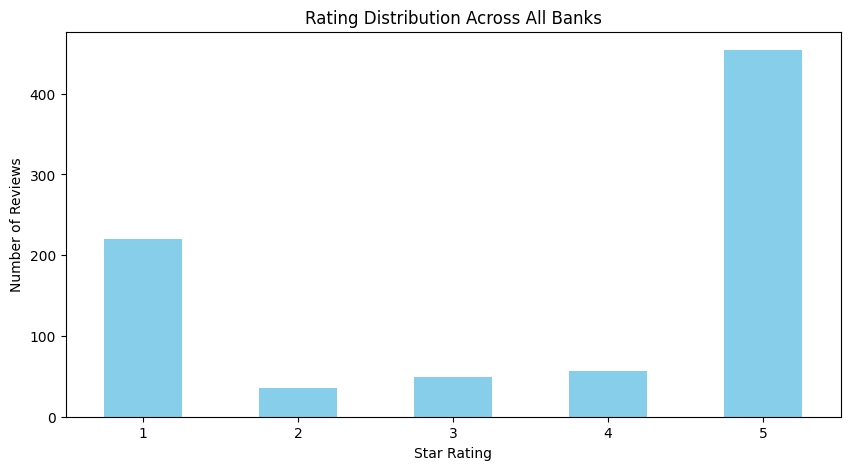

C:\Users\hp\AppData\Local\Temp\ipykernel_13352\2596827804.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df.set_index('date').resample('M')['review'].count().plot()


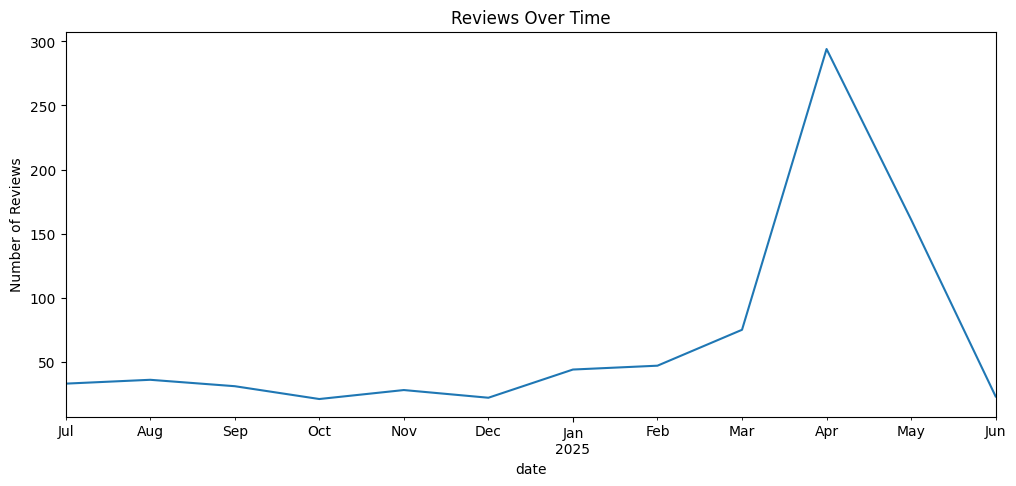

In [64]:
if not clean_dfs:
    raise ValueError("No data available for analysis")

# Rating distribution
plt.figure(figsize=(10, 5))
combined_df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rating Distribution Across All Banks')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

# %%
# Reviews over time (if date column exists)
if 'date' in combined_df.columns:
    plt.figure(figsize=(12, 5))
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    combined_df.set_index('date').resample('M')['review'].count().plot()
    plt.title('Reviews Over Time')
    plt.ylabel('Number of Reviews')
    plt.show()